In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import openpathsampling as paths
import openpathsampling.engines.toy as toys
import numpy as np

# used for visualization of the 2D toy system
# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py

# Reactive Flux Simulation

This example demonstrates how a reactive flux simulation is carried out and analyzed in OPS.

## Theory

In transition state theory the rate constant of a rare event can be expressed as a product

$$ k_{AB}^{TST} = \left< \dot{\lambda} \, \theta(\dot{\lambda}) \right>_{\lambda = \lambda^*} \cdot \frac{e^{-\beta F(\lambda^*)}}{\int_{-\infty}^{\lambda^*} e^{-\beta F(\lambda')} d\lambda'}\text{,}$$

where $F(\lambda)$ is the free energy with respect to a suitable reaction coordinate $\lambda(x)$ ($x$ is a system state). The dividing surface at $\lambda = \lambda^*$ separates the stable states $A$ and $B$, and $\left<\ldots\right>_{\lambda = \lambda^*}$ denotes a constrained average at this transition states. The first factor measures an average velocity of the reaction coordinate at the dividing surface when trajectories cross the barrier (note how the $\theta(\dot{\lambda})$ function selects only paths in the direction $A \rightarrow B$). The second factor is the probability for the system to be at the top of the barrier. This implies knowledge of the free energy curve with respect to the reaction coordinate, a quantity which may be obtained via umbrella sampling techniques.

A rate constant obtained from transition state theory is only correct if the reaction coordinate is chosen in such a way that no recrossings at the dividing surface occur, i.e. $\left\{x\, |\, \lambda(x) = \lambda^*\right\}$ corresponds to the *separatrix*. Frequently, for complex systems this requirement cannot be met and one has to correct the above expression with the transmission coefficient $\kappa(t) = k_{AB} \, / \, k_{AB}^{TST}$, where $k_{AB}$ is the true rate constant. Several expressions for $\kappa$ exist, e.g. the Bennet-Chandler or the positive flux version.

Here, we demonstrate how rate constants can be calculated in OpenPathSampling with the `ReactiveFluxSimulation` and `ReactiveFluxAnalysis` classes. These implement the *effective positive flux* method which is closely related to transition state theory but takes into account barrier recrossings. The above expression is modified to

$$ k_{AB}^{EPF} = \left< \dot{\lambda_0} \, \theta(\dot{\lambda_0}) \, \chi(x_0) \right>_{\lambda_0 = \lambda^*} \cdot \frac{e^{-\beta F(\lambda^*)}}{\int_{-\infty}^{\lambda^*} e^{-\beta F(\lambda')} d\lambda'}$$

where the first factor ("*flux*") is calculated via a shooting algorithm with starting points $x_0$ at the dividing surface. Backward and forward shots are carried out and the function $\chi$ guarantees that barrier recrossings are correctly handled in the following way: for a trajectory started in $x_0$ the function $\chi(x_0)$ evaluates to $1$ if the backward shot reaches $A$ before crossing $\lambda^*$ and the forward shot reaches $B$ before $A$, otherwise $\chi(x_0) = 0$. Note that this method requires a rather strict definition of the states $A$ and $B$ where both represent clearly separated, long-lived stable states. The computation of $\dot{\lambda_0}$ is implemented via the gradient of the reaction coordinate $\lambda$:

$$ \dot{\lambda_0} = \left.\frac{d \lambda}{d t}\right|_{x_0} = \nabla \lambda \cdot \left.\frac{d x}{d t}\right|_{x_0} = \nabla \lambda_0 \cdot v_0\text{,}$$

where $v_0$ are the temperature dependent, randomly chosen velocities at the shooting point.

## Example: Trajectory sampling

First, we set up our simple test system, a single particle in a 2-dimensional potential energy surface consisting of two gaussian wells and outer walls. The particle is propagated with the `LangevinBAOABIntegrator`.

In [2]:
depth = -0.7
width = 5.0

gaussian_A_depth  = depth
gaussian_A_alpha  = np.array([width, width])
gaussian_A_center = np.array([-0.5, -0.5])

gaussian_B_depth  = depth
gaussian_B_alpha  = np.array([width, width])
gaussian_B_center = np.array([0.5, 0.5])

pes = (
    toys.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.Gaussian(gaussian_A_depth, gaussian_A_alpha, gaussian_A_center) +
    toys.Gaussian(gaussian_B_depth, gaussian_B_alpha, gaussian_B_center)
)

topology = toys.Topology(
    n_atoms = 1,
    n_spatial = 2,
    masses = [1.0],
    pes = pes
)

dt = 0.02
temperature = 0.1
gamma = 2.5
integ = toys.LangevinBAOABIntegrator(dt, temperature, gamma)
options = {
    'integ' : integ,
    'n_frames_max' : 5000,
    'n_steps_per_frame' : 1
}

toy_eng = toys.Engine(
    options = options,
    topology = topology
)
toy_eng.initialized = True
paths.PathMover.engine = toy_eng

Furthermore we need a method to define states $A$ and $B$, we use circles around the respective gaussian well centers:

In [3]:
def circle2D(snapshot, center):
    import math
    return math.sqrt((snapshot.xyz[0][0]-center[0])**2 + (snapshot.xyz[0][1]-center[1])**2)

cv_A = paths.CoordinateFunctionCV(name="cv_A", f=circle2D, center=gaussian_A_center)
cv_B = paths.CoordinateFunctionCV(name="cv_B", f=circle2D, center=gaussian_B_center)

state_A = paths.CVDefinedVolume(cv_A, 0.0, 0.1)
state_B = paths.CVDefinedVolume(cv_B, 0.0, 0.1)

Given the symmetry of the system the dividing surface is the line $g$ defined by
$$g: x - y = 0\,\text{.}$$
Thus, as a reaction coordinate we can use the distance of the particle position $\vec{r}$ to the center of $A$ normalized by the total distance to both gaussian centers $\vec{a}, \vec{b}$:
$$\lambda(\vec{r}) = \frac{\left|\vec{r} - \vec{a}\right|}{\left|\vec{r} - \vec{a}\right| + \left|\vec{r} - \vec{b}\right|}\,\text{.}$$
This definition will provide $\lambda = 0.5$ everywhere on the dividing surface and $\lambda$ will decrease/increase further along paths towards A/B, respectively.

In [4]:
def flambda(snapshot, center_A, center_B):
    import math
    x = snapshot.xyz[0][0]
    y = snapshot.xyz[0][1]
    dist_A = math.sqrt((x - center_A[0])**2 + (y - center_A[1])**2)    
    dist_B = math.sqrt((x - center_B[0])**2 + (y - center_B[1])**2)
    return dist_A / (dist_A + dist_B)

rc = paths.CoordinateFunctionCV(name="rc", f=flambda,
                                center_A=gaussian_A_center,
                                center_B=gaussian_B_center)

Next the initial snapshots are randomly chosen along the dividing surface according to their Boltzmann weight $e^{-\beta E(x_0)}$ (rejection sampling). Usually these configurations are available from a preceding simulation, e.g. umbrella sampling.

In [5]:
def Epot(pos):
    toy_eng.positions = np.array([pos[0], pos[1]])
    return pes.V(toy_eng)

# Increase this number to get better statistics!
# num_points = 200
num_points = 4
points = []
p_max = np.exp(-Epot([0.0, 0.0])/temperature)
while len(points) < num_points:
    x = np.random.uniform(-1.0, 1.0)
    p = np.random.uniform(0.0, p_max)
    if p < np.exp(-Epot([x, -x])/temperature):
        points += [np.array([[x, -x]])]

template = toys.Snapshot(
    coordinates = np.array([[0.0, 0.0]]),
    velocities = np.array([[0.0, 0.0]]),
    engine = toy_eng
)

snapshots = [template.copy_with_replacement(coordinates=point) for point in points]

Let's plot the potential energy and the corresponding weight along the dividing surface:

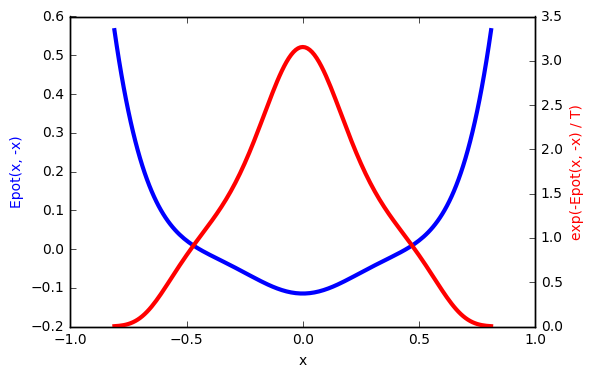

In [6]:
delta = 0.01
x = np.arange(-0.81, 0.811, delta)
y1 = [Epot([x[i], -x[i]]) for i in range(len(x))]
y2 = [np.exp(-Epot([x[i], -x[i]])/temperature) for i in range(len(x))]
fig, ax1 = plt.subplots()
ax1.plot(x, y1, 'b-', lw=3)
ax1.set_xlabel('x')
ax1.set_ylabel('Epot(x, -x)', color = 'b')
ax2 = ax1.twinx()
ax2.plot(x, y2, 'r-', lw=3)
ax2.set_ylabel('exp(-Epot(x, -x) / T)', color = 'r')

Here is a plot of the current setup with the potential energy surface, the two states A and B, the reaction coordinate and the starting points for the reactive flux shooting.

<a list of 9 text.Text objects>

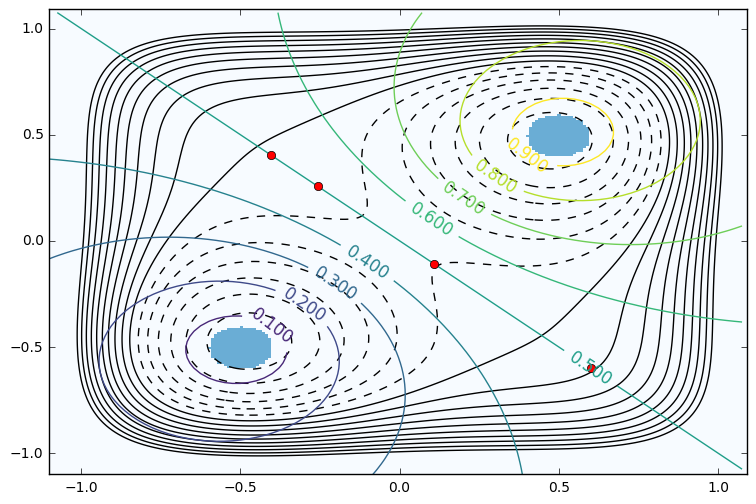

In [7]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)
plot.add_states([state_A, state_B])
fig = plot.plot()

ax = fig.get_axes()[0]
ax.plot([p[0][0] for p in points], [p[0][1] for p in points],'or')

delta = 0.025
x = np.arange(-1.1, 1.1, delta)
y = np.arange(-1.1, 1.1, delta)
X, Y = np.meshgrid(x, y)
p_xy = [np.array([[i[0], i[1]]]) for i in np.array([X.flatten(), Y.flatten()]).T]
template = toys.Snapshot(
    coordinates = np.array([[0.0, 0.0]]),
)
P = [template.copy_with_replacement(coordinates=xy) for xy in p_xy]
Z = np.array([flambda(p, gaussian_A_center, gaussian_B_center) for p in P]).reshape(len(X), len(X[0]))
levels = np.arange(0.0,1.0,0.1)
CS = ax.contour(X, Y, Z, levels=levels, cmap=cm.viridis)
manual_locations = [(-0.4, -0.4), (-0.3, -0.3), (-0.2, -0.2), (-0.1, -0.1), (0.6, -0.6),
                    (0.1, 0.1),(0.2, 0.2), (0.3, 0.3), (0.4, 0.4)]
ax.clabel(CS, inline=1, fontsize=12, manual=manual_locations)

Finally, we need a randomizer for velocities and a storage object:

In [8]:
randomizer = paths.RandomVelocities(1.0 / temperature)
storage = paths.Storage("rf-2d.nc", mode="w", template=template)

Now all ingredients are combined to form the reactive flux simulation:

In [9]:
simulation = paths.ReactiveFluxSimulation(
    storage = storage,
    engine = toy_eng,
    states = [state_A, state_B],
    randomizer = randomizer,
    initial_snapshots = snapshots,
    rc = rc
)

Upon calling the `run` method the trajectories are harvested and saved.

In [10]:
%%time
# Increase this number to get better statistics!
#n_per_snapshot = 20
n_per_snapshot = 5
simulation.run(n_per_snapshot=n_per_snapshot)

Working on snapshot 4 / 4; shot 5 / 5CPU times: user 19.4 s, sys: 368 ms, total: 19.7 s
Wall time: 19.7 s


Let's plot some of the obtained trajectories (one per initial snapshot):

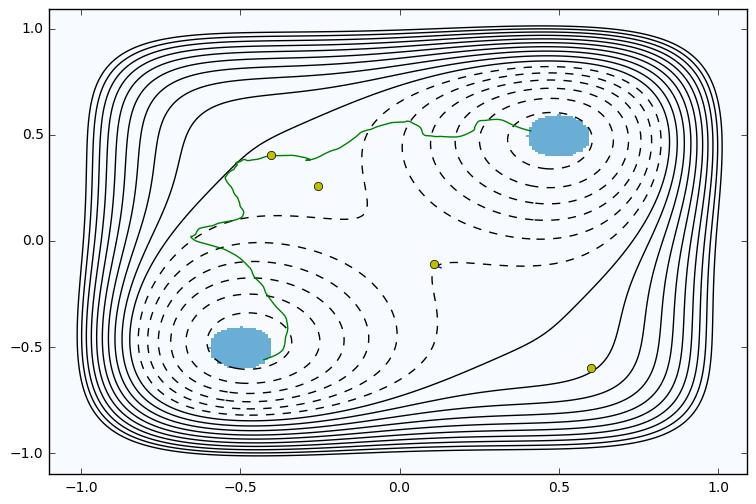

In [11]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)
plot.add_states([state_A, state_B])
fig = plot.plot([s.change.trials[-1].trajectory for s in storage.steps[::n_per_snapshot]])
ax = fig.get_axes()[0]
ax.plot([p[0][0] for p in points], [p[0][1] for p in points],'oy')

Check whether the maximum trajectory length (5000) is never used:

In [12]:
max([len(s.change.trials[-1].trajectory) for s in storage.steps])

987

In [13]:
storage.close()

## Example: Reactive Flux Analysis

Given the data from the reactive flux simulation we can now analyze the harvested trajectories. First, open the data file with the previously generated trajectories:

In [14]:
storage = paths.Storage("rf-2d.nc", "r")

To carry out the reactive flux analysis the gradient of the reaction coordinate is required. Given $\lambda(\vec{r})$ in the reactive flux simulation section we compute:
$$\vec{\nabla}\lambda(\vec{r}) = \frac{\frac{\left|\vec{r} - \vec{b}\right|}{\left|\vec{r} - \vec{a}\right|}\left(\vec{r} - \vec{a}\right)-\frac{\left|\vec{r} - \vec{a}\right|}{\left|\vec{r} - \vec{b}\right|}\left(\vec{r} - \vec{b}\right)}{\left(\left|\vec{r} - \vec{a}\right| + \left|\vec{r} - \vec{b}\right|\right)^2}\,\text{,}$$
which simplifies at the dividing surface $\left|\vec{r} - \vec{a}\right| = \left|\vec{r} - \vec{b}\right|$ to:
$$\vec{\nabla}\lambda(\vec{r}) = \frac{\vec{b} - \vec{a}}{4 \left|\vec{r} - \vec{a}\right|^2}\,\text{.}$$


In [15]:
def dflambda(snapshot, center_A, center_B):
    import numpy as np
    x = snapshot.xyz[0][0]
    y = snapshot.xyz[0][1]
    dist2_A = (x - center_A[0])**2 + (y - center_A[1])**2
    return np.array([(center_B - center_A) / (4 * dist2_A)])

gradient = paths.CoordinateFunctionCV(name="gradient", f=dflambda,
                                      center_A=gaussian_A_center, center_B=gaussian_B_center)

Now start the reactive flux analysis and extract the results:

In [16]:
%%time
results = paths.ReactiveFluxAnalysis(steps=storage.steps, gradient=gradient)

CPU times: user 660 ms, sys: 12 ms, total: 672 ms
Wall time: 671 ms


The `flux()` method extracts the total *flux*

$$\left< \dot{\lambda_0} \, \theta(\dot{\lambda_0}) \, \chi(x_0) \right>_{\lambda_0 = \lambda^*}$$

averaged over all configurations and a dictionary with per-snapshot values.

In [17]:
flux, flux_dict = results.flux()
flux

0.045634679064993508

It's possible to extract raw data for each snapshot with this method (note: ordering may be different than in the original `snapshots` list):

In [18]:
snapshot = flux_dict.keys()[0]
results[snapshot]

Counter({'accepted': 1, 'rejected': 4, 'sumflux': 0.20930828579780514})

Here, the `accepted` and `rejected` counters show how often trajectories from this starting point were accepted and the `sumflux` value is
$$
\sum_{i=0}^{n} \dot{\lambda_{0i}} \, \theta(\dot{\lambda_{0i}}) \, \chi(x_{0i}) \text{,}
$$
where $n$ is the number of trial moves and $x_{0i}$ is the initial configuration with randomly selected velocities of trial move $i$. Consequently, the average for this snapshot is:

In [19]:
flux_dict[snapshot]

0.04186165715956103

The `flux_histogram` method can be used to display the results with any bin selection:

/home/andi/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


<Container object of 21 artists>

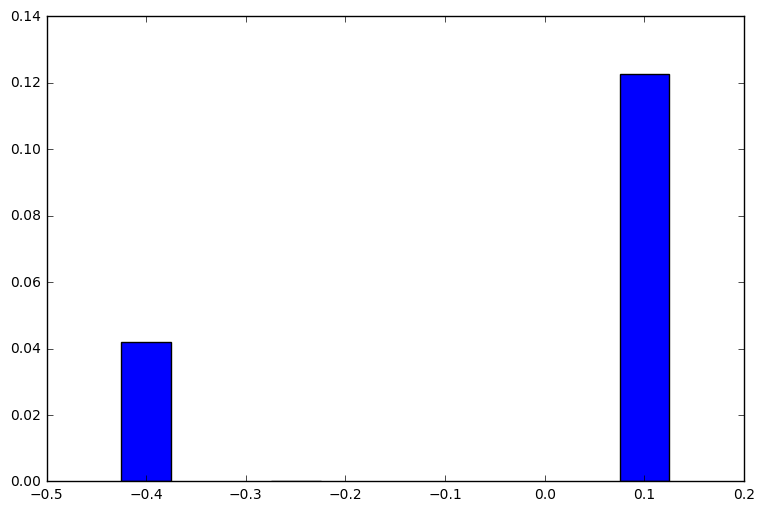

In [20]:
hash1D = lambda snap: snap.xyz[0][0]
bins1D = [-0.525 + i * 0.05 for i in range(22)]
hist, bins_x = results.flux_histogram(hash1D, bins1D)
plt.bar(left=bins1D[:-1], height=hist, width=[bins1D[i+1]-bins1D[i] for i in range(len(bins1D)-1)])

Also 2-dimensional histograms are possible:

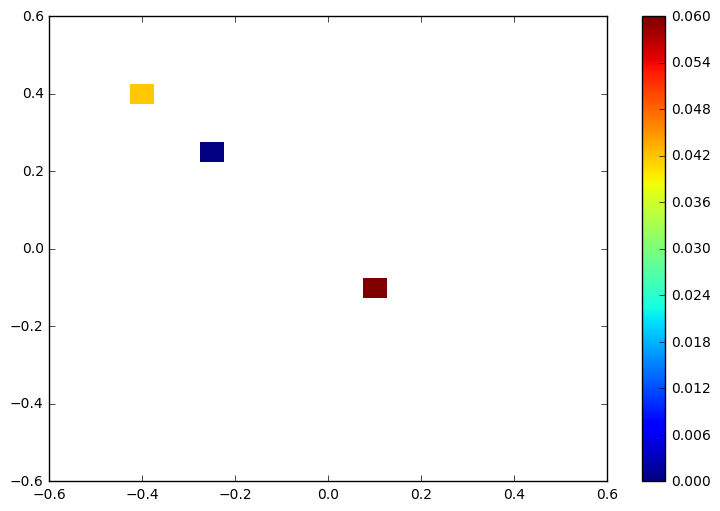

In [21]:
hash2D = lambda snap: (snap.xyz[0][0], snap.xyz[0][1])
bins2D = [-0.525 + i * 0.05 for i in range(22)]
hist, bins_x, bins_y = results.flux_histogram(hash2D, bins2D)
plt.pcolor(bins_x, bins_y, hist.T)
plt.clim(0.0, 0.06)
plt.colorbar();